MSE-train final loss: 0.04872, train acc: 0.8929, test acc: 0.8292
BCE-train final loss: 0.29433, train acc: 0.8893, test acc: 0.8208
Sklearn logistic (lbfgs) train acc: 0.8893, test acc: 0.8208


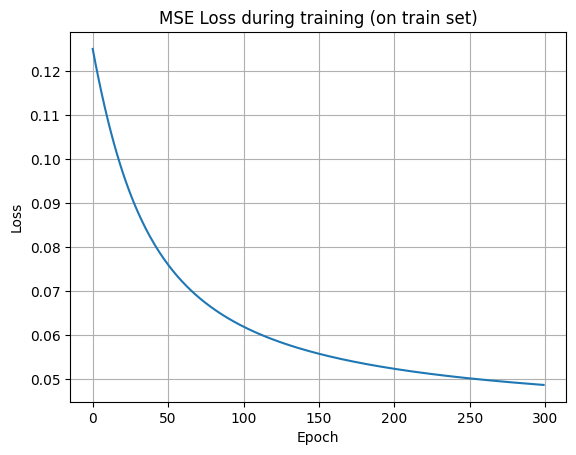

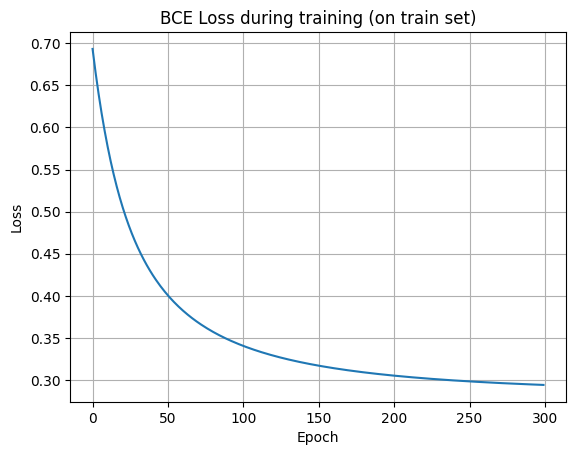

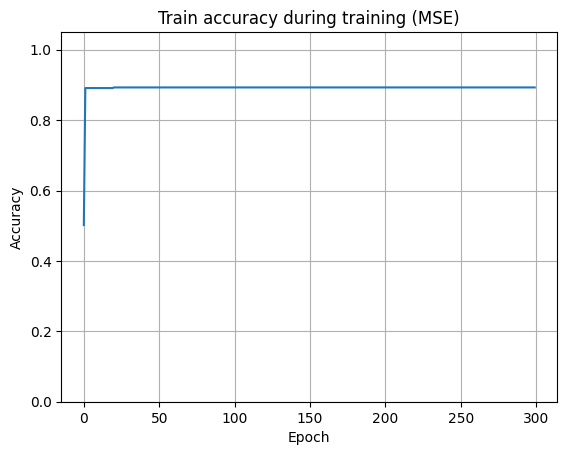

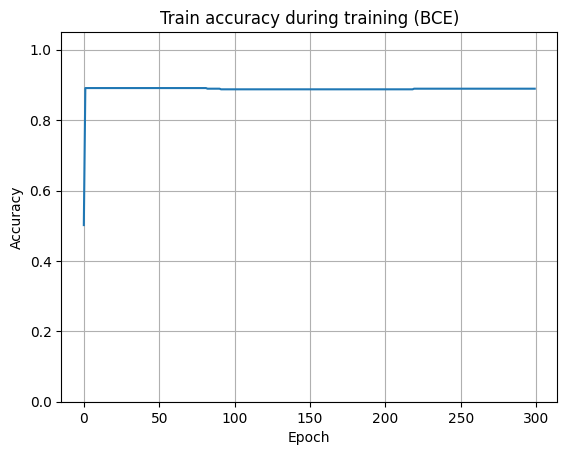

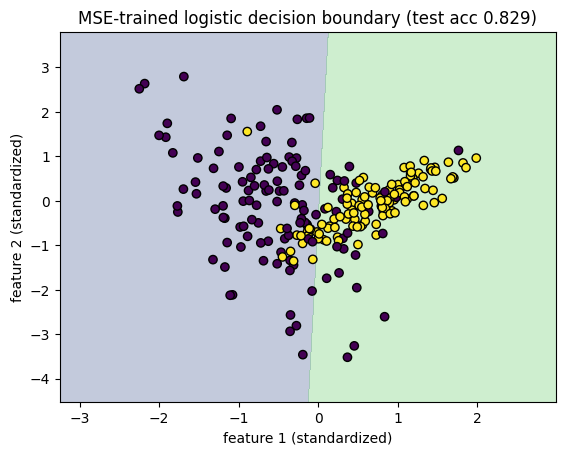

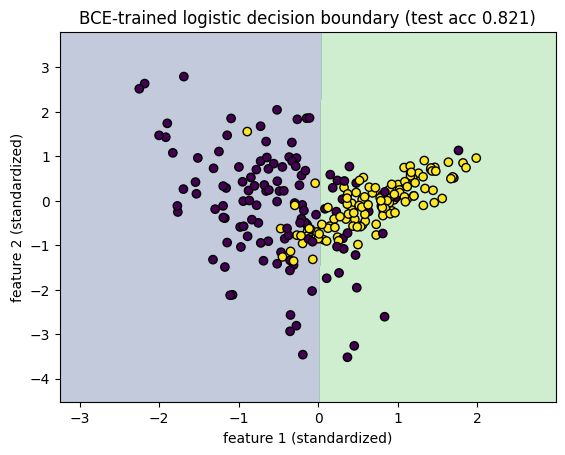

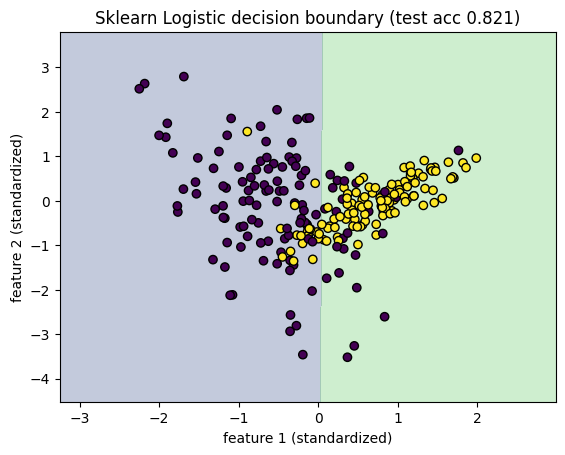

              model  train_acc  test_acc  final_loss_train
0      MSE_logistic   0.892857  0.829167          0.048718
1      BCE_logistic   0.889286  0.820833          0.294333
2  Sklearn_Logistic   0.889286  0.820833               NaN


In [1]:
# Python code to run three experiments comparing MSE vs BCE for Logistic Regression
# This code will be executed and the outputs (plots, numbers) will be visible to you.
# It implements simple gradient descent for:
# 1) Logistic model trained with MSE loss (not recommended)
# 2) Logistic model trained with BCE (binary cross-entropy) - standard
# 3) scikit-learn LogisticRegression (for reference)
#
# Notes per your UI rules:
# - Uses matplotlib (no seaborn), each chart in its own figure
# - Creates synthetic 2D dataset for clear visualization
# - Runs quickly (few epochs) and displays loss and accuracy curves and decision boundaries
#
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression as SklearnLogReg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

np.random.seed(42)

# Create a simple 2D binary classification problem (linearly separable-ish)
X, y = make_classification(n_samples=800, n_features=2, n_redundant=0, n_informative=2,
                            n_clusters_per_class=1, class_sep=1.2, flip_y=0.05, random_state=42)

# add bias term inside training routine; keep X as 2D features for plotting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

m, n = X_train_s.shape

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def accuracy(y_true, y_pred_prob):
    preds = (y_pred_prob >= 0.5).astype(int)
    return np.mean(preds == y_true)

# Add bias column
def add_bias(X):
    return np.hstack([np.ones((X.shape[0], 1)), X])

Xtr = add_bias(X_train_s)
Xte = add_bias(X_test_s)

# Experiment hyperparams
lr = 0.1
epochs = 300

# Initialize weights
def init_theta():
    return np.zeros(Xtr.shape[1])

# Training with MSE loss on logistic outputs
theta_mse = init_theta().copy()
loss_history_mse = []
acc_history_mse = []

for epoch in range(epochs):
    z = Xtr @ theta_mse
    yhat = sigmoid(z)
    # MSE loss
    loss = np.mean((yhat - y_train)**2) / 2.0
    loss_history_mse.append(loss)
    acc_history_mse.append(accuracy(y_train, yhat))
    # gradient: ∂/∂θ = (2/m) X^T [ (yhat - y) * yhat*(1-yhat) ]  (derived previously)
    grad = (2.0 / m) * (Xtr.T @ ((yhat - y_train) * (yhat * (1 - yhat))))
    theta_mse -= lr * grad

# Training with BCE loss (standard logistic regression)
theta_bce = init_theta().copy()
loss_history_bce = []
acc_history_bce = []

for epoch in range(epochs):
    z = Xtr @ theta_bce
    yhat = sigmoid(z)
    # BCE loss (average)
    eps = 1e-12
    loss = -np.mean(y_train * np.log(yhat + eps) + (1 - y_train) * np.log(1 - yhat + eps))
    loss_history_bce.append(loss)
    acc_history_bce.append(accuracy(y_train, yhat))
    # gradient for BCE: (1/m) X^T (yhat - y)
    grad = (1.0 / m) * (Xtr.T @ (yhat - y_train))
    theta_bce -= lr * grad

# Train sklearn logistic regression (lbfgs) for reference
clf = SklearnLogReg().fit(X_train_s, y_train)
sk_pred_tr = clf.predict_proba(X_train_s)[:,1]
sk_pred_te = clf.predict_proba(X_test_s)[:,1]
sk_acc_tr = accuracy(y_train, sk_pred_tr)
sk_acc_te = accuracy(y_test, sk_pred_te)

# Evaluate on test set
yhat_test_mse = sigmoid(Xte @ theta_mse)
yhat_test_bce = sigmoid(Xte @ theta_bce)
acc_test_mse = accuracy(y_test, yhat_test_mse)
acc_test_bce = accuracy(y_test, yhat_test_bce)

# Print final metrics
print(f"MSE-train final loss: {loss_history_mse[-1]:.5f}, train acc: {acc_history_mse[-1]:.4f}, test acc: {acc_test_mse:.4f}")
print(f"BCE-train final loss: {loss_history_bce[-1]:.5f}, train acc: {acc_history_bce[-1]:.4f}, test acc: {acc_test_bce:.4f}")
print(f"Sklearn logistic (lbfgs) train acc: {sk_acc_tr:.4f}, test acc: {sk_acc_te:.4f}")

# Plotting: each plot in its own figure as requested
# 1) Loss curve for MSE training
plt.figure()
plt.plot(loss_history_mse)
plt.title("MSE Loss during training (on train set)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# 2) Loss curve for BCE training
plt.figure()
plt.plot(loss_history_bce)
plt.title("BCE Loss during training (on train set)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# 3) Accuracy curves (train) — MSE and BCE in separate figures per rule
plt.figure()
plt.plot(acc_history_mse)
plt.title("Train accuracy during training (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0,1.05)
plt.grid(True)
plt.show()

plt.figure()
plt.plot(acc_history_bce)
plt.title("Train accuracy during training (BCE)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0,1.05)
plt.grid(True)
plt.show()

# 4) Decision boundary plots for each model (MSE, BCE, sklearn) on test set
def plot_decision_boundary(theta, title):
    # grid
    xx = np.linspace(X_test_s[:,0].min()-1, X_test_s[:,0].max()+1, 200)
    yy = np.linspace(X_test_s[:,1].min()-1, X_test_s[:,1].max()+1, 200)
    XX, YY = np.meshgrid(xx, yy)
    grid = np.c_[XX.ravel(), YY.ravel()]
    grid_b = add_bias(grid)
    Z = sigmoid(grid_b @ theta).reshape(XX.shape)
    plt.figure()
    plt.contourf(XX, YY, Z, levels=[-0.01,0.5,1.01], alpha=0.3)
    plt.scatter(X_test_s[:,0], X_test_s[:,1], c=y_test, edgecolor='k')
    plt.title(title)
    plt.xlabel("feature 1 (standardized)")
    plt.ylabel("feature 2 (standardized)")
    plt.show()

plot_decision_boundary(theta_mse, f"MSE-trained logistic decision boundary (test acc {acc_test_mse:.3f})")
plot_decision_boundary(theta_bce, f"BCE-trained logistic decision boundary (test acc {acc_test_bce:.3f})")

# sklearn decision boundary
# construct theta-like grid evaluation using sklearn coefficients
coef = np.hstack([clf.intercept_, clf.coef_.ravel()])
# sklearn uses intercept + coef * x, but our add_bias grid aligns with that ordering
plot_decision_boundary(coef, f"Sklearn Logistic decision boundary (test acc {sk_acc_te:.3f})")

# Present a small table of final metrics
import pandas as pd
df = pd.DataFrame({
    "model": ["MSE_logistic", "BCE_logistic", "Sklearn_Logistic"],
    "train_acc": [acc_history_mse[-1], acc_history_bce[-1], sk_acc_tr],
    "test_acc": [acc_test_mse, acc_test_bce, sk_acc_te],
    "final_loss_train": [loss_history_mse[-1], loss_history_bce[-1], np.nan]
})
print(df)
# import ace_tools as tools; tools.display_dataframe_to_user("experiment_results", df)

# # Save models for later if desired
# import joblib
# joblib.dump({"theta_mse": theta_mse, "theta_bce": theta_bce, "sklearn": clf}, "/mnt/data/logistic_experiments_models.pkl")
# print("Saved models to /mnt/data/logistic_experiments_models.pkl")
